In [1]:
!pip install scipy

Initial height h0 [m] (default 500.0): 20000
Initial downward velocity v0 [m/s] (use negative for downward; default -50.0): -100

=== BASIC KINEMATICS ===
g           = -9.810 m/s^2 (gravity, upward positive)
h0          = 20000.000 m (initial height)
v0          = -100.000 m/s (initial velocity; negative = downward)

Suicide-burn height (simple constant-decels model): d_sb = 509.684 m
Current height is ABOVE suicide-burn height (you can wait a bit).

Time to impact under free fall: t_impact = 54.470 s
Special time formula t = (sqrt(2) - 1)/g * v0 = 4.222 s (only valid in the special case).

=== ROCKET ODE SIMULATION (simple model) ===
Initial mass m0      = 20000.0 kg
Dry mass m_dry       = 10000.0 kg
Mass flow |dm/dt|    = 150.0 kg/s
Thrust               = 392400.0 N (T/W ≈ 2.00 at t=0)
Burn start time      = 0.000 s

No touchdown detected within t_max; try increasing t_max or adjusting thrust/initial conditions.


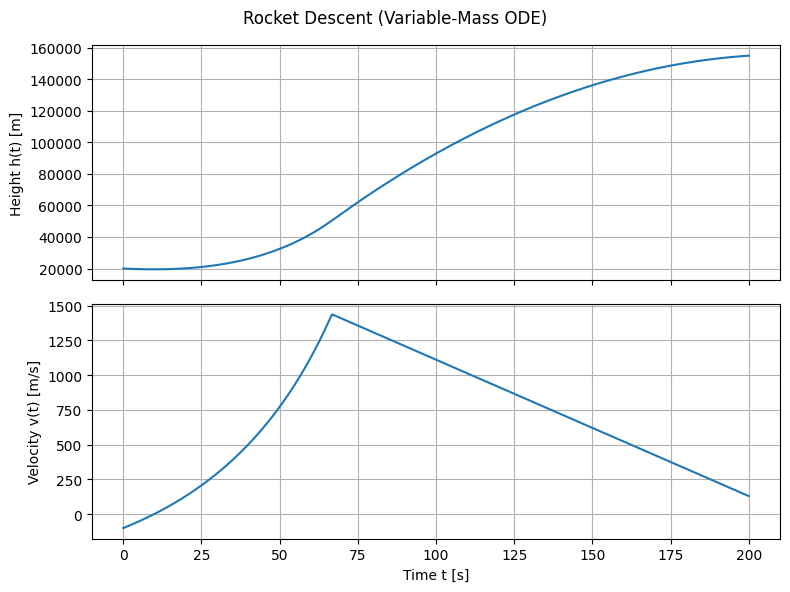

In [3]:
"""
Simple suicide-burn / rocket landing sandbox.

Sign convention used throughout:
- Upward is positive (+y).
- Ground is at h = 0 (h > 0 means above the ground).
- Gravity g is NEGATIVE (e.g., g = -9.81 m/s^2).
- Downward velocities are NEGATIVE.

This script does three main things:

1. KINEMATICS (no thrust):
   - Given initial height h0 and initial downward velocity v0 (negative),
     it computes:
       * Suicide-burn height d_sb = -v0^2 / (2 * g)
       * Time-to-impact from the general motion equation:
           0 = h0 + v0 t + (1/2) g t^2
       * The special time formula:
           t = (sqrt(2) - 1) / g * v0
         (valid only in the special suicide-burn setup discussed earlier).

2. ROCKET ODE (variable-mass, thrust, gravity, no drag):
   - Solves m(t) dv/dt + dm/dt * v = T_eff(t, h) - m g
   - State vector: [h, v, m]
   - You can specify:
       * Thrust (constant for now)
       * Mass flow rate
       * Initial mass and dry mass
       * Time when you start the burn

3. PLOTTING (optional):
   - Plots height and velocity vs. time from the ODE solution.

This is written to be easy to expand later (e.g., variable thrust,
altitude-dependent gravity, drag, guidance law, etc.).
"""

import math
from dataclasses import dataclass

import numpy as np
import matplotlib.pyplot as plt

# If scipy is not installed in your environment:
#   pip install scipy
from scipy.integrate import solve_ivp


# ==========================
# 1) BASIC KINEMATIC HELPERS
# ==========================

def suicide_burn_height(v0: float, g: float) -> float:
    """
    Suicide-burn height (distance needed to brake to zero velocity)
    in the simplest constant-acceleration model.

    Uses the formula:
        d = -v0^2 / (2 g)

    Here:
      - v0 is the (downward) velocity at the *start* of the burn.
        With our convention, v0 < 0 for downward motion.
      - g is the constant (signed) deceleration due to thrust.
        In the special symmetric case we discussed earlier, we reuse
        the same 'g' as gravity (also negative).

    For g < 0 and v0 < 0, d > 0.
    """
    return -v0**2 / (2.0 * g)


def time_to_impact_free_fall(h0: float, v0: float, g: float) -> float | None:
    """
    Time to impact (h = 0) under pure free fall with gravity g,
    starting from height h0 and velocity v0.

    Motion equation:
        h(t) = h0 + v0 t + (1/2) g t^2
    Impact condition:
        h(t) = 0  =>  0 = h0 + v0 t + 0.5 g t^2

    Solve quadratic:
        a t^2 + b t + c = 0
      where
        a = 0.5 g
        b = v0
        c = h0

    Returns the physically relevant positive root (if any),
    or None if there is no real positive solution.
    """
    a = 0.5 * g
    b = v0
    c = h0

    disc = b*b - 4.0*a*c
    if disc < 0:
        return None

    sqrt_disc = math.sqrt(disc)
    t1 = (-b - sqrt_disc) / (2.0 * a)
    t2 = (-b + sqrt_disc) / (2.0 * a)

    # Select positive roots (if any) and take the earliest positive time
    candidates = [t for t in (t1, t2) if t >= 0.0]
    return min(candidates) if candidates else None


def special_time_formula(v0: float, g: float) -> float:
    """
    Special time formula:
        t = (sqrt(2) - 1) / g * v0

    IMPORTANT:
    - This comes from plugging the suicide-burn height into the
      general motion equation.
    - It is only valid in the specific 'suicide-burn' setup we
      discussed (constant deceleration with the same |g|, etc.).
    - With our convention, v0 < 0 and g < 0 => t > 0.
    """
    return (math.sqrt(2.0) - 1.0) * v0 / g


# ================================
# 2) VARIABLE-MASS ROCKET DYNAMICS
# ================================

@dataclass
class RocketParams:
    """
    Parameters for the rocket ODE model.
    """
    g: float = -9.81        # gravitational acceleration (m/s^2), upward positive, so g < 0
    thrust: float = 0.0     # constant thrust (N), positive = upward
    m0: float = 20000.0     # initial total mass (kg)
    mdot: float = 0.0       # positive mass flow rate (kg/s), |dm/dt|
    m_dry: float = 10000.0  # dry mass (kg) -> minimum mass
    t_burn_start: float = 0.0  # time when engine starts (s)


def rocket_rhs(t: float, y: np.ndarray, params: RocketParams) -> list[float]:
    """
    Right-hand side of the rocket ODE:

        State y = [h, v, m]
        where
          h = altitude above ground (m), up is positive
          v = vertical velocity (m/s), up is positive
          m = mass (kg)

    Rocket equation (1D, no drag):

        m dv/dt + (dm/dt) v = T_eff(t, h) - m g

    Here:
      - g is NEGATIVE (gravity points downward).
      - T_eff(t, h) is thrust (positive upward).
      - dm/dt is negative while burning (mass decreasing).
    """
    h, v, m = y

    # Gravity magnitude
    g_mag = -params.g  # g < 0, so g_mag > 0

    # Simple thrust schedule:
    #   Engine ON if t >= t_burn_start, mass > dry mass, and h > 0
    #   Engine OFF otherwise.
    if (t >= params.t_burn_start) and (m > params.m_dry) and (h > 0.0):
        T = params.thrust           # upward thrust
        dmdt = -params.mdot         # mass is decreasing
    else:
        T = 0.0
        dmdt = 0.0

    # Avoid division by zero after we've hit dry mass.
    m_eff = max(m, params.m_dry)

    # Rocket equation:
    #   m dv/dt + (dm/dt) v = T - m g_mag
    #   => dv/dt = (T - m * g_mag - v * dmdt) / m
    dvdt = (T - m_eff * g_mag - v * dmdt) / m_eff

    dhdt = v

    return [dhdt, dvdt, dmdt]


def touchdown_event(t: float, y: np.ndarray, params: RocketParams) -> float:
    """
    Event function to stop integration when h = 0 (touchdown).

    Returns h; when h crosses zero, the event fires.
    """
    h, v, m = y
    return h


# Mark the event as terminal and only triggering when crossing downward.
touchdown_event.terminal = True
touchdown_event.direction = -1.0


def simulate_rocket_descent(h0: float,
                            v0: float,
                            params: RocketParams,
                            t_max: float = 200.0):
    """
    Simulates the rocket's descent from (h0, v0, m0) with the
    given RocketParams.

    Returns the scipy.integrate.solve_ivp solution object.
    """
    y0 = [h0, v0, params.m0]

    sol = solve_ivp(
        fun=lambda t, y: rocket_rhs(t, y, params),
        t_span=(0.0, t_max),
        y0=y0,
        max_step=0.1,
        events=lambda t, y: touchdown_event(t, y, params),
        dense_output=False
    )
    return sol


# =====================
# 3) MAIN DEMO / DRIVER
# =====================

if __name__ == "__main__":
    # ------------------------
    # USER-EDITABLE PARAMETERS
    # ------------------------

    # Gravitational acceleration (upward positive, so g < 0).
    g = -9.81  # m/s^2

    # Default initial conditions:
    #   h0 = initial altitude above ground (m)
    #   v0 = initial vertical velocity (m/s), NEGATIVE = downward
    h0_default = 500.0   # meters
    v0_default = -50.0   # m/s (downward)

    # You can either edit these defaults directly,
    # or just press Enter at the prompts to use them.
    try:
        h0_in = input(f"Initial height h0 [m] (default {h0_default}): ").strip()
        v0_in = input(
            f"Initial downward velocity v0 [m/s] (use negative for downward; "
            f"default {v0_default}): "
        ).strip()
    except EOFError:
        # If input() is not available (e.g. running non-interactively),
        # fall back to defaults.
        h0_in = ""
        v0_in = ""

    h0 = float(h0_in) if h0_in else h0_default

    if v0_in:
        v0 = float(v0_in)
        # If user mistakenly enters a positive number, interpret it
        # as a *downward speed* and convert to negative velocity.
        if v0 > 0.0:
            print(
                f"Interpreting positive input {v0:.3f} m/s as a downward speed; "
                f"using v0 = {-v0:.3f} m/s."
            )
            v0 = -v0
    else:
        v0 = v0_default

    print("\n=== BASIC KINEMATICS ===")
    print(f"g           = {g:.3f} m/s^2 (gravity, upward positive)")
    print(f"h0          = {h0:.3f} m (initial height)")
    print(f"v0          = {v0:.3f} m/s (initial velocity; negative = downward)")

    # 1) Suicide-burn height for this v0 using g as the deceleration
    d_sb = suicide_burn_height(v0, g)
    print(f"\nSuicide-burn height (simple constant-decels model): d_sb = {d_sb:.3f} m")

    if h0 > d_sb:
        print("Current height is ABOVE suicide-burn height (you can wait a bit).")
    elif math.isclose(h0, d_sb, rel_tol=1e-3, abs_tol=1e-3):
        print("Current height is approximately AT the suicide-burn height.")
    else:
        print("Current height is BELOW suicide-burn height (you are too low).")

    # 2) Time to impact under pure free fall (no thrust)
    t_impact = time_to_impact_free_fall(h0, v0, g)
    if t_impact is not None:
        print(f"\nTime to impact under free fall: t_impact = {t_impact:.3f} s")
    else:
        print("\nNo real positive time-to-impact solution for these inputs.")

    # 3) Special time formula (only valid in the specific suicide-burn setup)
    t_special = special_time_formula(v0, g)
    print(
        f"Special time formula t = (sqrt(2) - 1)/g * v0 = {t_special:.3f} s "
        "(only valid in the special case)."
    )

    # -------------------------------
    # ROCKET ODE: SIMPLE LANDING DEMO
    # -------------------------------
    print("\n=== ROCKET ODE SIMULATION (simple model) ===")

    # Example rocket parameters (edit these freely)
    m0 = 20000.0        # initial mass (kg)
    m_dry = 10000.0     # dry mass (kg)
    mdot = 150.0        # mass flow rate (kg/s)
    g_mag = -g          # 9.81

    # Choose thrust as a multiple of the initial weight (TWR > 1)
    thrust_to_weight_ratio = 2.0
    thrust = thrust_to_weight_ratio * m0 * g_mag  # N
    t_burn_start = 0.0  # start burning immediately at t = 0

    params = RocketParams(
        g=g,
        thrust=thrust,
        m0=m0,
        mdot=mdot,
        m_dry=m_dry,
        t_burn_start=t_burn_start,
    )

    print(f"Initial mass m0      = {m0:.1f} kg")
    print(f"Dry mass m_dry       = {m_dry:.1f} kg")
    print(f"Mass flow |dm/dt|    = {mdot:.1f} kg/s")
    print(f"Thrust               = {thrust:.1f} N "
          f"(T/W ≈ {thrust_to_weight_ratio:.2f} at t=0)")
    print(f"Burn start time      = {t_burn_start:.3f} s")

    # Simulate descent with the engine on according to this schedule
    t_max = 200.0  # max simulation time (s)
    sol = simulate_rocket_descent(h0, v0, params, t_max=t_max)

    if sol.t_events[0].size > 0:
        t_touchdown = sol.t_events[0][0]
        h_touchdown, v_touchdown, m_touchdown = sol.y_events[0][0]
        print(f"\nTouchdown detected at t = {t_touchdown:.3f} s")
        print(f"  h(touchdown) = {h_touchdown:.3f} m (should be ~0)")
        print(f"  v(touchdown) = {v_touchdown:.3f} m/s")
        print(f"  m(touchdown) = {m_touchdown:.3f} kg")
    else:
        print("\nNo touchdown detected within t_max; "
              "try increasing t_max or adjusting thrust/initial conditions.")

    # ====================================
    # OPTIONAL: PLOT HEIGHT / VELOCITY VS T
    # ====================================
    DO_PLOT = True

    if DO_PLOT and sol.t.size > 1:
        t_arr = sol.t
        h_arr = sol.y[0, :]
        v_arr = sol.y[1, :]

        fig, axes = plt.subplots(2, 1, figsize=(8, 6), sharex=True)

        axes[0].plot(t_arr, h_arr)
        axes[0].set_ylabel("Height h(t) [m]")
        axes[0].grid(True)

        axes[1].plot(t_arr, v_arr)
        axes[1].set_xlabel("Time t [s]")
        axes[1].set_ylabel("Velocity v(t) [m/s]")
        axes[1].grid(True)

        fig.suptitle("Rocket Descent (Variable-Mass ODE)")
        plt.tight_layout()
        plt.show()
